In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pyfits
import pandas as pd
import os
from astroML.stats import binned_statistic_2d
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['axes.labelsize'] = 16

In [2]:
#Define directory where data is
cwd = "/astro/store/scratch/tmp/EXD"

#Change directories to where data is for processing
os.chdir(cwd)

In [3]:
def funcStdDev(vector):
    return np.sqrt(np.var(vector))

In [4]:
def plotPanel(axes,xVec,yVec,zVec,CCstat="",CCtype="",xMin="",xMax="",yMin="",yMax="",xLabel="",yLabel="",title="",CONFLAG=False): 
    
    #For plotting depending on whether conservative Fe/H, Teff cuts were made
    if CONFLAG:
        FeHMin = -1.1
        FeHSteps = 0.5
    else:
        FeHMin = -2.5
        FeHSteps = 1
    
    
    # axes limits
    if (xMin==""): xMin = np.min(xVec)
    if (xMax==""): xMax = np.max(xVec)
    axes.set_xlim(xMin, xMax)
    if (yMin==""): yMin = np.min(yVec)
    if (yMax==""): yMax = np.max(yVec)
    axes.set_ylim(yMin, yMax)
    # axes labels
    axes.text(-1.5, 0.2, yLabel, color='black')
    axes.set_xlabel(xLabel, fontsize=14)

    # title 
    axes.set_title(title)
    # make bigger ticmark labels
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(12) 
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(12) 

    # bin
    N, xedges, yedges = binned_statistic_2d(xVec, yVec, zVec,'count', bins=100)
    if (CCstat==""):
        Zmean, xedges, yedges = binned_statistic_2d(xVec, yVec, zVec,'mean', bins=100)
    else:
        Zmean, xedges, yedges = binned_statistic_2d(xVec, yVec, zVec,funcStdDev, bins=100)

    # plot
    cmap_multicolor = plt.cm.jet
    cmap_multicolor.set_bad('w', 1.)
    plt.imshow(Zmean.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap=cmap_multicolor)
    if (CCtype=="FeH"):
        cb = plt.colorbar(ticks=np.arange(FeHMin, 1, FeHSteps), pad=0.16,
                  format=r'$%.1f$', orientation='horizontal')
        #cb.set_label(r'$\mathrm{mean\ [Fe/H]\ in\ pixel}$', fontsize=12)
        plt.clim(FeHMin, 0.5)
    if (CCtype=="logg"):
        cb = plt.colorbar(ticks=np.arange(0, 4.1, 1), pad=0.16,
                  format=r'$%.1f$', orientation='horizontal')
        #cb.set_label(r'$\mathrm{mean\ log(g)\ in\ pixel}$', fontsize=12)
        plt.clim(0, 4)
    if (CCtype=="loggSmall"):
        plt.clim(0, 4)
    if (CCtype=="vRad"):
        cb = plt.colorbar(ticks=np.arange(0, 150, 25), pad=0.16,
                  format=r'$%.1f$', orientation='horizontal')
        cb.set_label(r'$\mathrm{\ vel. disp. (km/s) \ in\ pixel}$', fontsize=12)
        plt.clim(0, 150)

    # density contours over the colors
    if (1):
        levels = np.linspace(0, np.log10(N.max()), 7)[2:]
        plt.contour(np.log10(N.T), levels, colors='k',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

In [5]:
#Function to return subsection of data that's good
def cleanseData(data,ASPCAPFLAG=True,STARFLAG=True,PARAMFLAG=True,EXTRAFLAG=True,CONFLAG=True):
    """
    Searches bitmask data for the following conditions and returns the array in which all of them are false (i.e. good data).
    This function only searches for BAD flags and warnings are ingnored.
    Flags/values taken from sdss3.org/dr10/algorithms/bitmask_apogee_(name of flag).php.
    Also, flags noted in Holtzman+2015 are used for our metal case
    
    Flags:
    ASPCAPFLAG,...,CONFLAG settings determine which slice of data to remove.
    ASPCAPFLAG through EXTRATARG flag determine if the SDSS DR12 bitmask flags are used when filtering objects.
    CONFLAG determines if conserative cuts of the following format are made:
        Remove if:
                  Teff < 3800 K or Teff > 5250 K or low metallicities ([Fe/H] < -1) as defined
                  in http://www.sdss.org/dr12/irspec/abundances/
    
    
    Note: To convert from bit digits to normal numbers, n = 2^(bit digit)
    ex: 4 = 2^(bit 2)
    
    Input:
    APOGEE data array containing 15 metals .fits data named "allStar-v603.fits"
    
    Output: 
    Data array containing all the objects without bad flags or the flags deemed bad for metals in Holtzman+2015
    
    Conditions of the form:
    
    condition: bitmask value
   
    ASPCAPFLAG:
    
    STAR_BAD: 23
    VMICRO_BAD: 18
    METALS_BAD: 19
    ALPHAFE_BAD: 20
    CFE_BAD: 21
    NFE_BAD: 22
    NO_ASPCAP_RESULT: 31
    
    STARFLAG:
    
    BAD_PIXELS: 0
    VERY_BRIGHT_NEIGHBOR: 3
    LOW_SNR: 4
    
    PARAMFLAG:
    
    GRIDEDGE_BAD: 0
    CALRANGE_BAD: 1
    OTHER_BAD: 2
    GRIDEDGE_WARN: 8
    """
    #Define arrays for bitmasks for each respective category
    ABits = data['ASPCAPFLAG']
    PBits = data['PARAMFLAG']
    SBits = data['STARFLAG']
    
    #Define lists of bits we're looking for
    ABitFlags = [18,19,20,21,22,23]
    PBitFlags = [0,1,2,8]
    SBitFlags = [0,3,4]
    
    #Define mask of trues
    mask = np.ones(len(data))
        
    #Loop over ASPCAPFLAGS
    aCounter = 0
    if ASPCAPFLAG:
        amask = mask
        for value in ABitFlags:
            n = 2**value
            mask = np.logical_and(amask,(np.bitwise_and(ABits,n) == 0))
        aCounter += np.sum(amask!=mask)
        print "Removed {0} objects using ASPCAPFLAG bitmasks.".format(aCounter)
     
    #Loop over PARAMFLAGS.  Must hold for all 7 params! (Teff,log(g), etc)
    pCounter = 0
    if PARAMFLAG:
        pmask = mask
        for i in range(0,7):
            for value in PBitFlags:
                n = 2**value             
                mask = np.logical_and(pmask,np.bitwise_and(PBits[:,i],n) == 0)
        pCounter += np.sum(pmask!=mask)
        print "Removed {0} objects using PARAMFLAG bitmasks.".format(pCounter)

    #Loop over STARFLAGS
    sCounter = 0
    if STARFLAG:
        smask = mask
        for value in SBitFlags:
            n = 2**value
            mask = np.logical_and(smask,(np.bitwise_and(SBits,n) == 0))
        sCounter += np.sum(smask!=mask)
        print "Removed {0} objects using STARFLAG bitmasks.".format(sCounter)

    #Get only main survey targets
    tCounter = 0
    if EXTRAFLAG:
        tmask = mask
        mask = np.logical_and(tmask,data["EXTRATARG"] == 0)
        tCounter += np.sum(tmask != mask)
        print "Removed {0} objects using EXTRATARG bitmasks.".format(tCounter)
    
    #Mask conservative Teff, Fe/H cuts
    cCounter = 0
    if CONFLAG:
        cmask = mask
        mask = np.logical_and(np.logical_and(np.logical_and(data['TEFF'] > 3800,data['TEFF'] < 5250),data['PARAM_M_H'] > -1),cmask)
        cCounter += np.sum(cmask != mask)
        print "Removed {0} objects using conservative Teff, Fe/H cuts.".format(cCounter)
        
    res = tCounter+aCounter+sCounter+pCounter+cCounter
    print "Total number of objects removed: {0}".format(res)
        
    return data[mask]

In [6]:
############################################################################# 
### read APOGEE parameters
tempdata = pyfits.open('allStar-v603.fits')[1].data  # 163,278
data = cleanseData(tempdata)

Removed 22859 objects using ASPCAPFLAG bitmasks.
Removed 49 objects using PARAMFLAG bitmasks.
Removed 0 objects using STARFLAG bitmasks.
Removed 39139 objects using EXTRATARG bitmasks.
Removed 21846 objects using conservative Teff, Fe/H cuts.
Total number of objects removed: 83893


In [7]:
# some ad hoc quality cuts 
OKcond = ((data['LOGG'] > -10) & (data['PARAM_M_H'] > -10))
OKcond = (OKcond & (data['J'] > -10) & (data['J'] < 30))
OKcond = (OKcond & (data['H'] > -10) & (data['H'] < 30))
OKcond = (OKcond & (data['K'] > -10) & (data['K'] < 30))
# and some more severe cuts
# we don't want very bright objects as they seem outliers (~500) 

# add some prelim flag cuts!!! KLW edit -- 2/24. make all flags = 0
#OKcond = (OKcond & (data['K'] > 6.0) * (data['STARFLAG'] == 0) & (data['ASPCAPFLAG'] == 0))
print len(data[OKcond])

79385


In [8]:
# full sky; 101,399
title = "                  APOGEE, full sky, color-coded by log(g)"

if (0):
    # high latitudes
    OKcond = (OKcond & (data['GLAT'] > 20.0))  # 19,249
    title = "                  APOGEE, b>20, color-coded by log(g)"

if (0):
    # low latitudes
    OKcond = (OKcond & (data['GLAT'] < 5.0) & (data['GLAT'] > -5.0))  # 43,002
    title = "                  APOGEE, |b|<5 deg., color-coded by log(g)"


In [11]:
## select good data and make vectors for convenience 
dataOK = data[OKcond]  
J = dataOK['J']
H = dataOK['H']
K = dataOK['K']
JK = J-K
logg = dataOK['LOGG']
Teff = dataOK['TEFF']
FeH = dataOK['PARAM_M_H']
alphaFe = dataOK['PARAM_ALPHA_M']
gLat = dataOK['GLAT']
W2 = dataOK['WISE_4_5']
KW2 = K-W2
vRad = dataOK['VHELIO_AVG']

/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/core/_methods.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


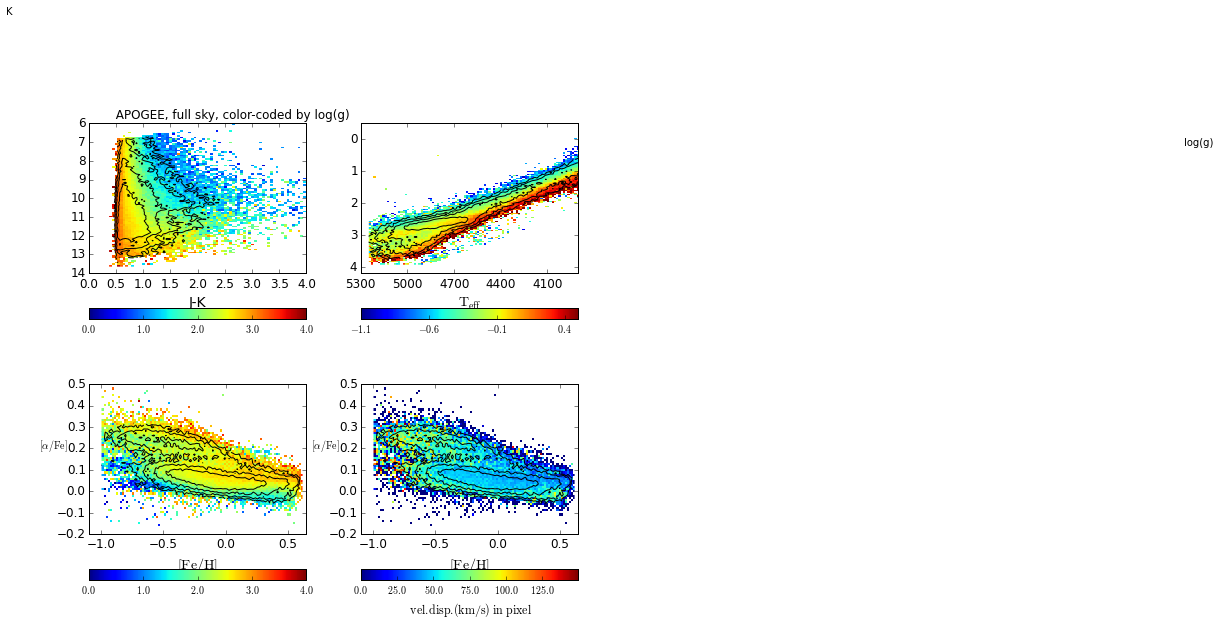

In [12]:
### plot

# Create figure and subplots
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(wspace=0.25, left=0.1, right=0.95, bottom=0.12, top=0.95)

### all these color-coded by the mean FeH 
# K vs. J-K color-magnitude diagram 
axes = plt.subplot(221)
plotPanel(axes, JK, K, logg, CCtype="logg", xMin=0.0, xMax=4.0, yMin=14.01, yMax=6.0,
          xLabel="J-K", yLabel="K", title=title,CONFLAG=True)

# logg vs. Teff, color-coded by mean FeH 
axes = plt.subplot(222, xticks=[3800, 4100, 4400, 4700, 5000, 5300])
plotPanel(axes, Teff, logg, FeH, CCtype="FeH", xMin=5300, xMax=3900, yMin=4.2, yMax=-0.5,
          xLabel=r'$\mathrm{T_{eff}}$', yLabel="log(g)",CONFLAG=True)

# [alpha/Fe] vs. [Fe/H], color-coded by logg
axes = plt.subplot(223)
plotPanel(axes, FeH, alphaFe, logg, CCtype="logg", xMin=-1.1, xMax=0.65, yMin=-0.2, yMax=0.5,
          xLabel=r'$\mathrm{[Fe/H]}}$', yLabel=r'$\mathrm{[\alpha/Fe]}}$',CONFLAG=True)


# [alpha/Fe] vs. [Fe/H], color-coded by radial velocity 
axes = plt.subplot(224)
plotPanel(axes, FeH, alphaFe, vRad, CCstat="stdev", CCtype="vRad", xMin=-1.1, xMax=0.65, yMin=-0.2, yMax=0.5,
          xLabel=r'$\mathrm{[Fe/H]}}$', yLabel=r'$\mathrm{[\alpha/Fe]}}$',CONFLAG=True)

plt.savefig('/astro/users/dflemin3/Desktop/apogee1.pdf')
plt.show() 

name =  AL_H  panel:  2
name =  CA_H  panel:  3
name =  C_H  panel:  4
name =  FE_H  panel:  5
name =  K_H  panel:  6
name =  MG_H  panel:  7
name =  MN_H  panel:  8
name =  NA_H  panel:  9
name =  NI_H  panel:  10
name =  N_H  panel:  11
name =  O_H  panel:  12
name =  SI_H  panel:  13
name =  S_H  panel:  14
name =  TI_H  panel:  15
name =  V_H  panel:  16


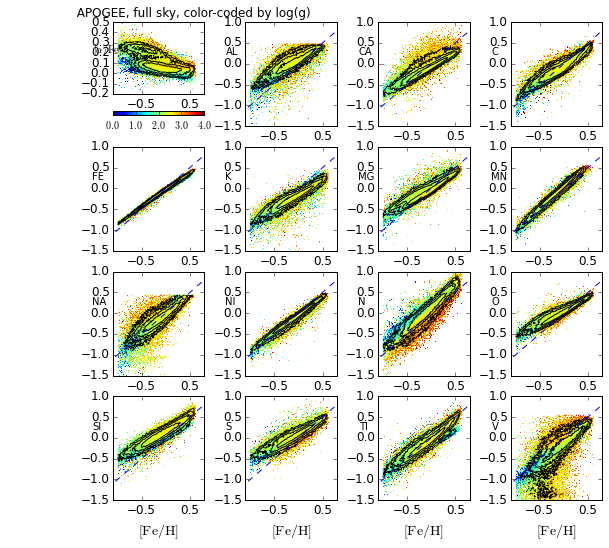

In [13]:
### plot

# Create figure and subplots
fig = plt.figure(figsize=(8, 8))
# this work well in *.py version but not so well in ipython notebook
fig.subplots_adjust(wspace=0.45, left=0.1, right=0.95, bottom=0.12, top=0.95)


# [alpha/Fe] vs. [Fe/H], color-coded by logg
axes = plt.subplot(441, xticks=[-1.5, -0.5, 0.5])
plotPanel(axes, FeH, alphaFe, logg, CCtype="logg", xMin=-1.1, xMax=0.8, yMin=-0.2, yMax=0.5,
          yLabel=r'$\mathrm{[\alpha/Fe]}}$', title=title)

plotNo = 1
elemList = ('AL', 'CA', 'C', 'FE', 'K', 'MG', 'MN', 'NA', 'NI', 'N', 'O', 'SI', 'S', 'TI', 'V')
for elem in elemList:
    name = elem + '_H'
    plotNo += 1
    print 'name = ', name, ' panel: ', plotNo
    axes = plt.subplot(4, 4, plotNo, xticks=[-1.5, -0.5, 0.5])
    condX = (dataOK[name] > -1.5) & (dataOK[name] < 1.0)
    xVec = FeH[condX]
    yVec = dataOK[name][condX]
    zVec = logg[condX]
    xLabel = ""
    if (plotNo > 12): xLabel='$\mathrm{[Fe/H]}}$'
    plotPanel(axes, xVec, yVec, zVec, CCtype="loggSmall", xMin=-1.1, xMax=0.8, yMin=-1.5, yMax=1.0,
          xLabel=xLabel, yLabel=elem)
    axes.plot([-1.8, 1.0], [-1.8, 1.0], 'b--', linewidth=1)

#plt.savefig('./apogee2.png')
plt.show() 

---
## PCA

In [14]:
from sklearn import decomposition
from sklearn.preprocessing import normalize

ncomp = 15
pca = decomposition.PCA(n_components=ncomp)

# alpha elements first          
arr0 =  (dataOK['O_H'], dataOK['MG_H'], dataOK['SI_H'], dataOK['S_H'], 
         dataOK['CA_H'], dataOK['TI_H'], dataOK['C_H'], dataOK['N_H'],
         dataOK['AL_H'], dataOK['MN_H'], dataOK['K_H'], dataOK['V_H'], 
         dataOK['NI_H'], dataOK['FE_H'], dataOK['NA_H'])

arr = normalize( np.array(arr0).transpose() )

#dflemin3 edit
#from sklearn.preprocessing import StandardScaler
#X_std = StandardScaler().fit_transform(np.array(arr0).transpose())

In [15]:
#pca.fit(X_std)
X = pca.fit_transform(arr)
evals = pca.explained_variance_ratio_

In [16]:
print X.shape

(79385, 15)


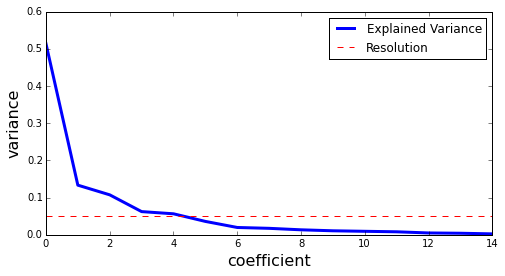

In [17]:
plt.figure(figsize=(8,4))

plt.plot(np.arange(len(X[0])), pca.explained_variance_ratio_, lw=3,label='Explained Variance')
plt.axhline(y=.05, xmin=0, xmax=15, linewidth=1, color = 'red',linestyle='--',label='Resolution')
plt.ylabel('variance')
plt.xlabel('coefficient')
plt.legend()
plt.show()

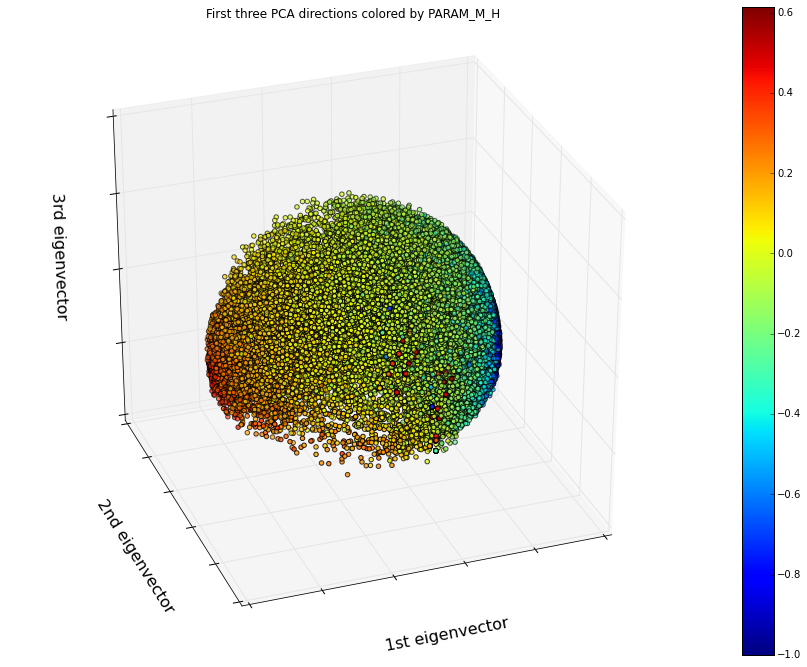

In [20]:
fig = plt.figure(1, figsize=(12, 9))
ax = Axes3D(fig, elev=-150, azim=110)
nn = len(X)

flag = "PARAM_M_H"

Y = (X,dataOK[flag][:nn])

p =ax.scatter(X[:, 0], X[:, 1], X[:, 2],c=dataOK[flag][:nn],cmap=plt.cm.jet)

ax.set_title("First three PCA directions colored by "+flag,y=1.06)
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])


fig.colorbar(p)
plt.show()

In [21]:
evals_cs = evals.cumsum()
evals_cs /= evals_cs[-1]
spec_mean = np.mean(arr,axis=0)

In [22]:
# Find the coefficients of a particular mock "spectrum"
spec = arr[222]
coeff = np.dot(X, spec - spec_mean)

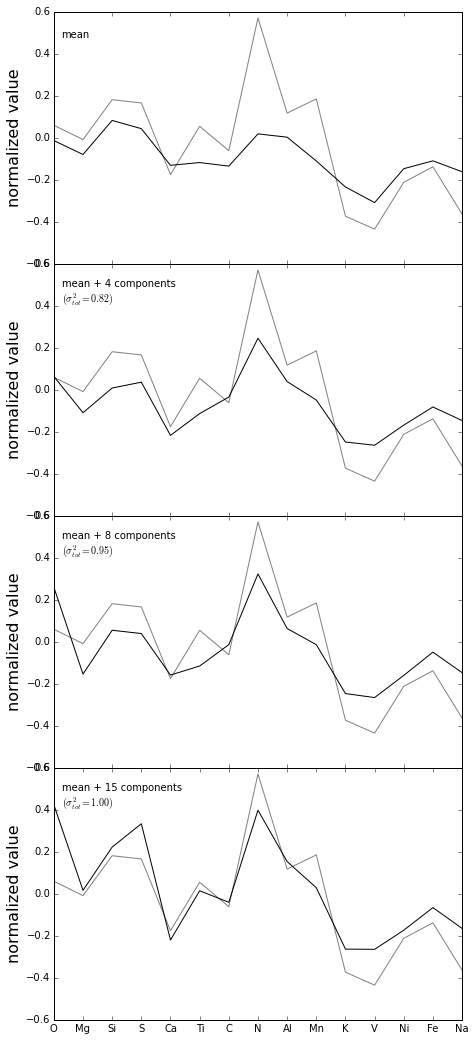

In [23]:
#------------------------------------------------------------
# Plot the sequence of reconstructions
fig = plt.figure(figsize=(7, 14))
fig.subplots_adjust(hspace=0, top=1, bottom=0., left=0.12, right=0.93)

wavelengths = np.arange(15)

for i, n in enumerate([0, 4, 8, 15]):
    ax = fig.add_subplot(411 + i)
    ax.plot(wavelengths, spec, '-', c='gray')
    ax.plot(wavelengths, spec_mean + np.dot(coeff[:n], X[:n]), '-k')
    
    if i < 3:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    #ax.set_ylim(-.9, .5)
    ax.set_ylabel('normalized value')

    if n == 0:
        text = "mean"
    elif n == 1:
        text = "mean + 1 component\n"
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
    else:
        text = "mean + %i components\n" % n
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]

    ax.text(0.02, 0.93, text, ha='left', va='top', transform=ax.transAxes)


labels=['O', 'Mg', 'Si', 'S', 'Ca', 'Ti', 'C', 'N', 'Al', 
        'Mn', 'K', 'V', 'Ni', 'Fe', 'Na']
plt.xticks(wavelengths, labels)
plt.show()

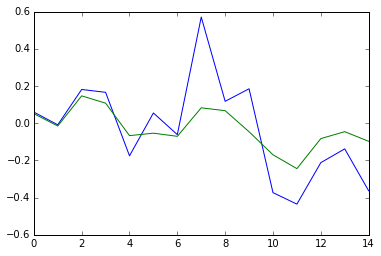

In [24]:
plt.plot(wavelengths, spec, wavelengths, spec_mean + np.dot(coeff[:11], evals[:11]))
#plt.plot(wavelengths, spec_mean + np.dot(coeff[:2], evals[:2]), '-k')
#plt.plot(wavelengths, spec_mean + np.dot(coeff[:6], evals[:6]), '-k')

#plt.ylim(-.35,.15)

In [25]:
pca.fit(arr)
X_reduced = pca.transform(arr)

/astro/apps6/anaconda2.0/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


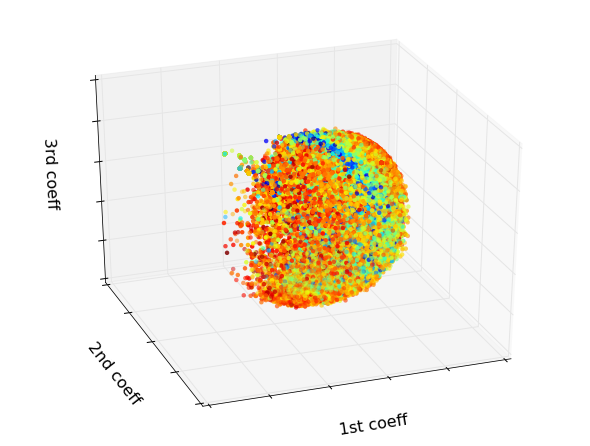

In [26]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
nn=len(X_reduced)
ax.scatter(X_reduced[:nn, 1], X_reduced[:nn, 2], X_reduced[:nn, 0], c=dataOK['TEFF'][:nn],
           cmap=plt.cm.jet, lw=0)
ax.set_title("")
ax.set_xlabel("1st coeff")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd coeff")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd coeff")
ax.w_zaxis.set_ticklabels([])
fig.show()

In [27]:
from astroML.plotting.tools import devectorize_axes


def black_bg_subplot(*args, **kwargs):
    """Create a subplot with black background"""
    kwargs['axisbg'] = 'k'
    ax = plt.subplot(*args, **kwargs)

    # set ticks and labels to white
    for spine in ax.spines.values():
        spine.set_color('w')

    for tick in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
        for child in tick.get_children():
            child.set_color('w')

    return ax


def compute_color(param1, param2):
    # define the base color scalings
    
  #  cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
  #  scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    
    
    R = np.ones_like(param1)-.2
    G = 0.5 * 10 ** (-8 * (param1 + 0.601))
    B = 1.9 * 10 ** (-2 * (param2 + 0.0))
    
    # normalize color of each point to its maximum component
    RGB = np.vstack([R, G, B])
    RGB /= RGB.max(0)

    # return an array of RGB colors, which is shape (n_points, 3)
    return RGB.T


#------------------------------------------------------------
# Fetch data and extract the desired quantities
FeH = dataOK['PARAM_M_H']
alphaFe = dataOK['PARAM_ALPHA_M']
logg = dataOK['LOGG']
teff = dataOK['TEFF']

good = (FeH > -10)

# compute RGB color based on magnitudes
color = compute_color(FeH[good], alphaFe[good])

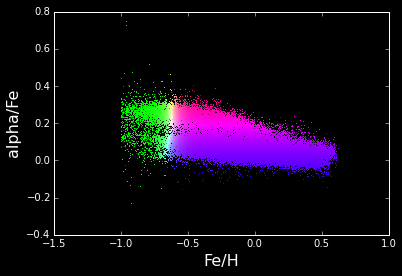

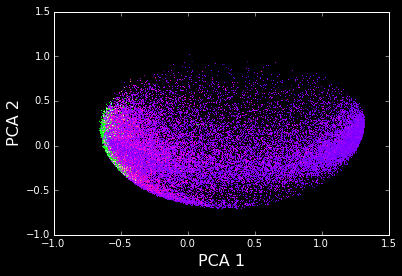

In [28]:
#------------------------------------------------------------
# set up the plot

# plot the color-magnitude plot
fig = plt.figure(facecolor='k')
ax = black_bg_subplot(111)
ax.scatter(FeH[good], alphaFe[good], c=color, s=1, lw=0)
devectorize_axes(ax, dpi=400)

#ax.set_xlim(-0.3, 0.4)
#ax.set_ylim(-0.8, 0.6)

ax.set_xlabel('Fe/H', color='w')
ax.set_ylabel('alpha/Fe', color='w')

# plot the orbital parameters plot
fig = plt.figure(facecolor='k')
ax = black_bg_subplot(111)

ax.scatter(X_reduced[:, 0][good], X_reduced[:, 1][good], c=color, s=1, lw=0)
devectorize_axes(ax, dpi=400)

#ax.set_xlim(2.0, 3.3)
#ax.set_ylim(-0.02, 0.3)

ax.set_xlabel('PCA 1', color='w')
ax.set_ylabel('PCA 2', color='w')

# label the plot
text_kwargs = dict(color='w', fontsize=14,
                   transform=plt.gca().transAxes,
                   ha='center', va='bottom')

# Saving the black-background figure requires some extra arguments:
#fig.savefig('moving_objects.png',
#            facecolor='black',
#            edgecolor='none')

plt.show()

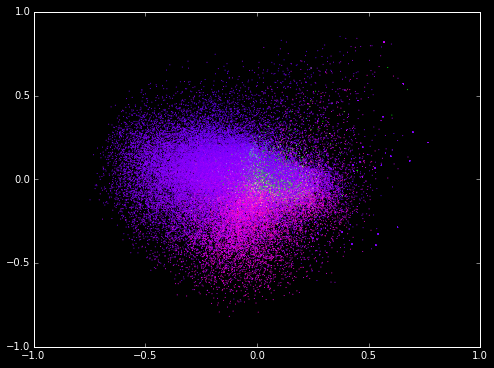

In [29]:
fig = plt.figure(facecolor='k', figsize=(8,6))
ax = black_bg_subplot(111)

ax.scatter(X_reduced[:, 2], X_reduced[:, 3], c=color, s=1, lw=0)
fig.show()

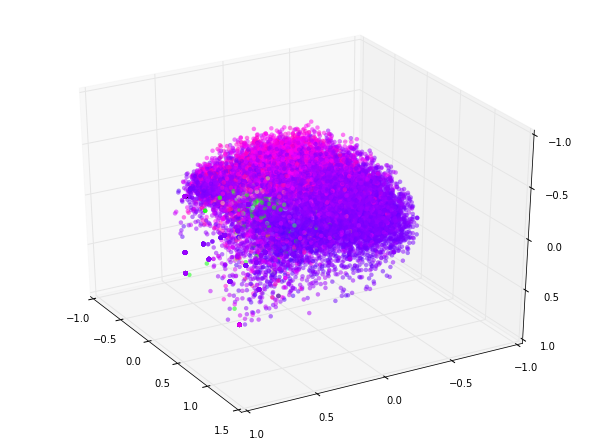

In [30]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=210)
ax.scatter(X_reduced[:, 1], X_reduced[:, 2], X_reduced[:, 3], c=color, lw=0, alpha=.5)
fig.show()

## 

---
practice:

In [31]:
def plot_PCA_projection(pca, colorby, comp1=0, comp2=1):

    y = dataOK[colorby]

    X_proj = pca.transform(X)

    # plot
    cmap_multicolor = plt.cm.jet
    cmap_multicolor.set_bad('w', 1.)
    
    N, xedges, yedges = binned_statistic_2d(X_proj[:,comp1], X_proj[:,comp2], 
                                            y, 'mean', bins=500)
        
    plt.imshow(N.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap=cmap_multicolor, vmin=np.min(yedges), vmax=np.max(yedges))

    plt.xlabel('coefficient ' + str(comp1))
    plt.ylabel('coefficient ' + str(comp2))

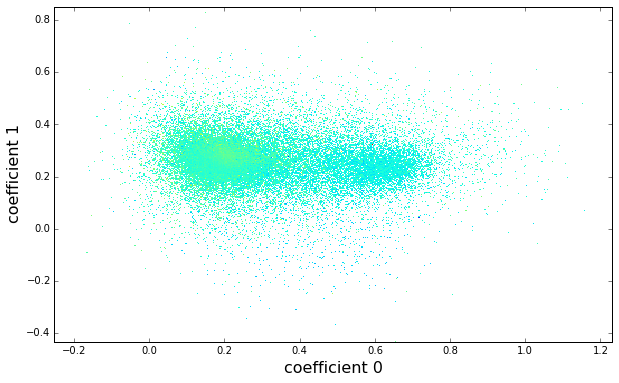

In [32]:
plt.figure(figsize=(10,6))
comp1 = 0
comp2 = 1
plot_PCA_projection(pca, 'PARAM_ALPHA_M', comp1, comp2)

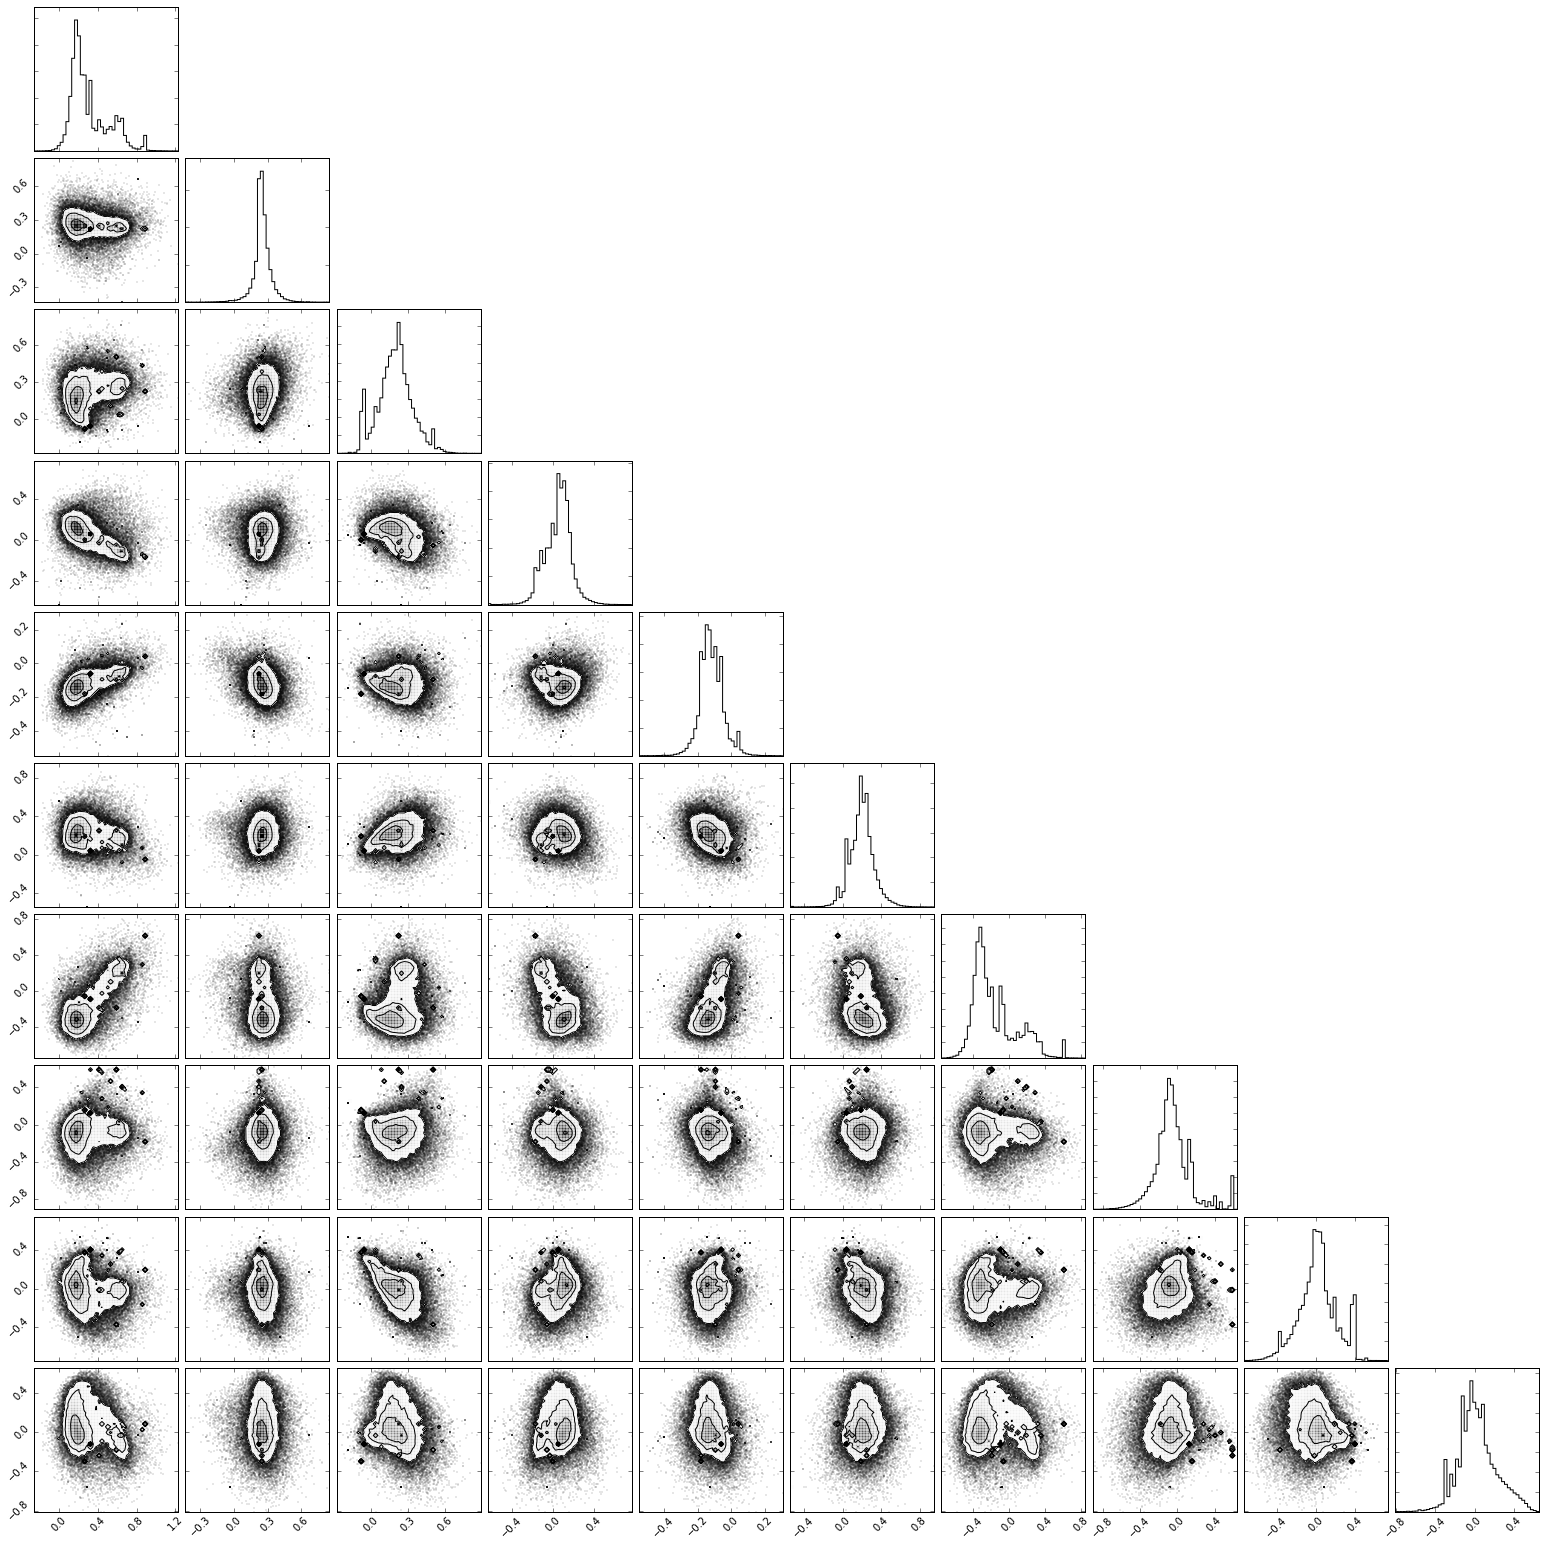

In [33]:
import triangle
coeff = pca.transform(X)

# plot first 7 components
figure = triangle.corner(coeff[:,:10])

In [36]:
from sklearn.decomposition import RandomizedPCA
rpca = RandomizedPCA(n_components=15, random_state=0)
X_proj = rpca.fit_transform(arr)
X_proj.shape

(79385, 15)

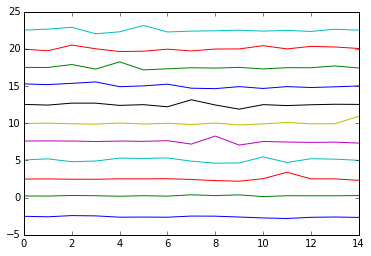

In [37]:
wavelengths = np.arange(15)

plt.plot(wavelengths, rpca.mean_ - 2.5)

for i in range(10):
    plt.plot(wavelengths, rpca.components_[i] + 2.5 * i)

plt.show()

#Triangle plot of element abundances

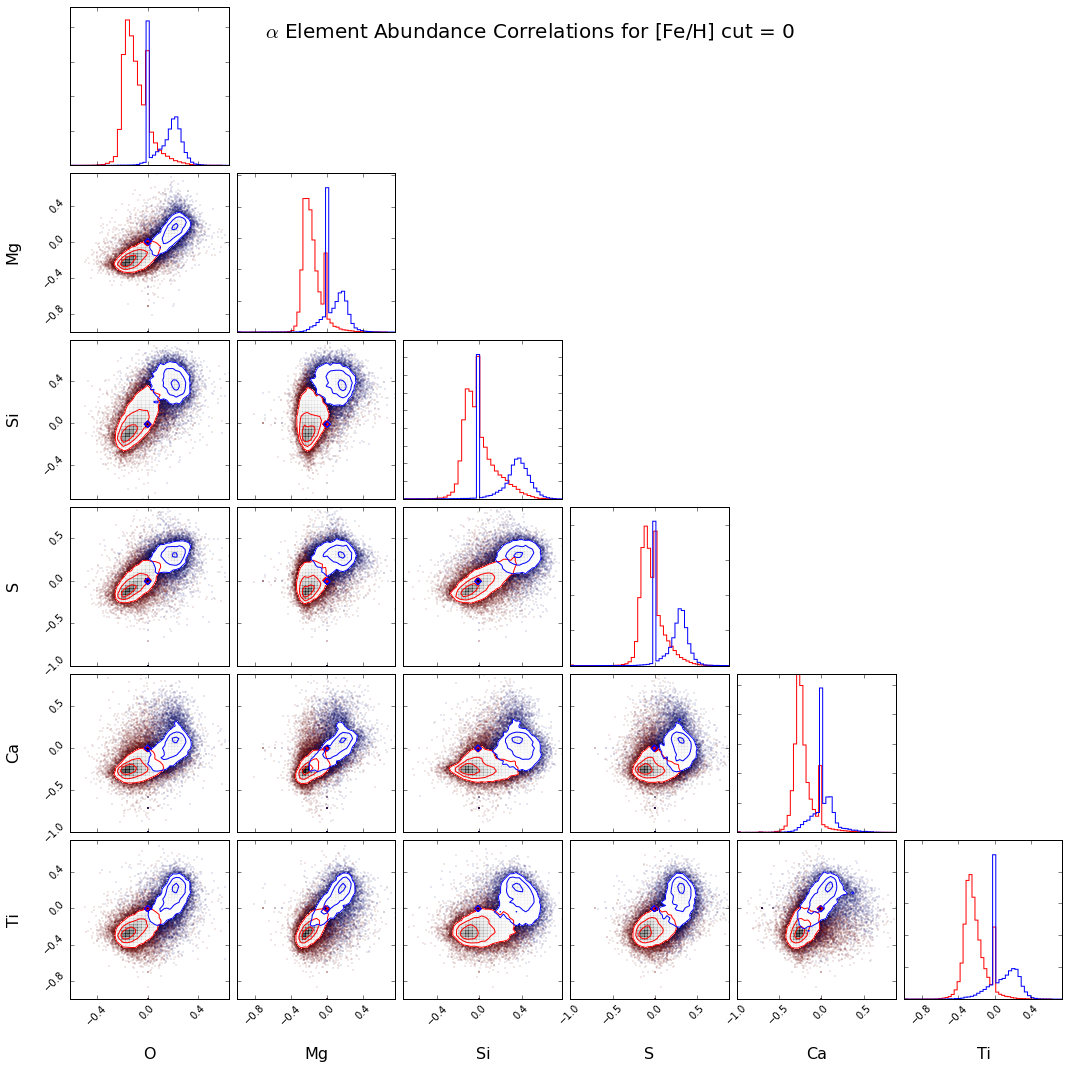

In [76]:
label_list = ["O", "Mg", "Si", "S", "Ca", "Ti", "C", "N", "Al", 
              "Mn", "K", "V", "Ni", "Fe", "Na"]


lower = 0
upper = 6
dim = len(arr[0])

K = upper - lower
fig, axes = plt.subplots(K, K, figsize=(dim, dim))
    
mask = dataOK["PARAM_M_H"] < 0

arrHalo = arr[mask]
arrDisk = arr[~mask]

figure = triangle.corner(arrHalo[:,lower:upper],labels=label_list[lower:upper],fig=fig,color='red')
figure = triangle.corner(arrDisk[:,lower:upper],labels=label_list[lower:upper],fig=fig,color='blue')
fig.suptitle(r"$\alpha$ Element Abundance Correlations for [Fe/H] cut = 0",fontsize=20)